In [2]:
import os
import warnings
from datetime import datetime

import pandas as pd
import requests

from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")


class Parser:
    CURRENCIES = dict(
        DOLLAR="R01235",
        EURO="R01239",
        YUAN="R01375",
        POUND="R01035"
    )
    WINLINE_TEMPLATE = (
        "https://www.cbr.ru/Queries/UniDbQuery/DownloadExcel/132934?"
        "FromDate=10%2F05%2F2014&"
        "ToDate={day:0>2}%2F{month:0>2}%2F{year}&posted=False"
    )
    CURRENCY_TEMPLATE = (
        "https://www.cbr.ru/Queries/UniDbQuery/DownloadExcel/98956?Posted=True&"
        "so=1&mode=1&VAL_NM_RQ={code}&"
        "From=01.07.2014&To={day:0>2}.{month:0>2}.{year}&"
        "FromDate=07%2F01%2F2014&"
        "ToDate={day:0>2}%2F{month:0>2}%2F{year}"
    )

    def __init__(self):
        self.rate = pd.DataFrame()
        self.currencies = pd.DataFrame(columns=["data", "curs", "cdx"])

    @staticmethod
    def replace_cdx(cdx):
        if cdx == "Доллар США":
            return "dollar"
        elif cdx == "Китайский юань":
            return "yuan"
        elif cdx == "Евро":
            return "euro"
        return "pound"

    def get_rate(self):
        url = self.WINLINE_TEMPLATE.format(
            day=datetime.now().day,
            month=datetime.now().month,
            year=datetime.now().year
        )
        self.rate = pd.read_excel(url)
        print("RATE PARSED")

    def get_currencies(self):
        for wallet, code in self.CURRENCIES.items():
            url = self.CURRENCY_TEMPLATE.format(
                day=datetime.now().day,
                month=datetime.now().month,
                year=datetime.now().year,
                code=code
            )
            wallet_rate = pd.read_excel(url)
            # wallet_rate = wallet_rate.drop(["cdx"], axis=1)
            self.currencies = pd.concat([self.currencies, wallet_rate.drop("nominal", axis=1)])
            print(f"{wallet} PARSED")

    def get_data(self):
        self.get_rate()
        self.get_currencies()
        # self.currencies.to_csv("123.csv", index=False)
        # self.rate.to_csv("124.csv", index=False)
        currencies = self.currencies.copy()
        currencies.cdx = currencies.cdx.apply(self.replace_cdx)
        currencies.data = currencies.data.apply(str)

        dollar = currencies.loc[currencies.cdx == "dollar"]
        euro = currencies.loc[currencies.cdx == "euro"]
        yuan = currencies.loc[currencies.cdx == "yuan"]
        pound = currencies.loc[currencies.cdx == "pound"]

        dollar["date2"] = dollar.data.apply(lambda x: "-".join(x.split("-")[:-1]))
        dollar = dollar.rename(columns={"curs": "dollar_curs"})

        euro["date2"] = euro.data.apply(lambda x: "-".join(x.split("-")[:-1]))
        euro = euro.rename(columns={"curs": "euro_curs"})

        yuan["date2"] = yuan.data.apply(lambda x: "-".join(x.split("-")[:-1]))
        yuan = yuan.rename(columns={"curs": "yuan_curs"})

        pound["date2"] = pound.data.apply(lambda x: "-".join(x.split("-")[:-1]))
        pound = pound.rename(columns={"curs": "pound_curs"})

        rate = self.rate.rename(columns={
            "Дата": "date2",
            "Ключевая ставка, % годовых": "rate",
            "Инфляция, % г/г": "inflation"
        })
        rate = rate.drop(["Цель по инфляции"], axis=1)

        rate.date2 = rate.date2.apply(lambda x: "{}-{:0>2}".format(*str(x).split(".")[::-1]))

        data = dollar[["dollar_curs", "date2", "data"]].merge(rate, on="date2")
        data = data.merge(euro[["euro_curs", "date2"]], on="date2")
        data = data.merge(pound[["pound_curs", "date2"]], on="date2")
        data = data.merge(yuan[["yuan_curs", "date2"]], on="date2")
        # data = data.drop("date2", axis=1)
        data = data.drop_duplicates(subset=['data'], keep='first')
        return data


Parser().get_data().to_csv("result.csv", index=False)

RATE PARSED
DOLLAR PARSED
EURO PARSED
YUAN PARSED
POUND PARSED


In [3]:
data = pd.read_csv('result.csv')

In [4]:
data

,dollar_curs,date2,data,rate,inflation,euro_curs,pound_curs,yuan_curs
0,91.8692,2024-02,2024-02-29 00:00:00,16.0,7.69,99.4500,116.5177,12.7085
1,92.0425,2024-02,2024-02-28 00:00:00,16.0,7.69,99.4500,116.5177,12.7085
2,92.6321,2024-02,2024-02-27 00:00:00,16.0,7.69,99.4500,116.5177,12.7085
3,92.7519,2024-02,2024-02-23 00:00:00,16.0,7.69,99.4500,116.5177,12.7085
4,92.4387,2024-02,2024-02-22 00:00:00,16.0,7.69,99.4500,116.5177,12.7085
...,...,...,...,...,...,...,...,...
2072,39.9820,2014-10,2014-10-07 00:00:00,8.0,8.29,54.6378,69.3181,70.9567
2073,39.6980,2014-10,2014-10-04 00:00:00,8.0,8.29,54.6378,69.3181,70.9567
2074,39.5474,2014-10,2014-10-03 00:00:00,8.0,8.29,54.6378,69.3181,70.9567
2075,39.6604,2014-10,2014-10-02 00:00:00,8.0,8.29,54.6378,69.3181,70.9567


In [5]:
data.isnull().sum()

dollar_curs    0
date2          0
data           0
rate           0
inflation      0
euro_curs      0
pound_curs     0
yuan_curs      0
dtype: int64

In [6]:
data = data.drop(["date2"], axis=1)

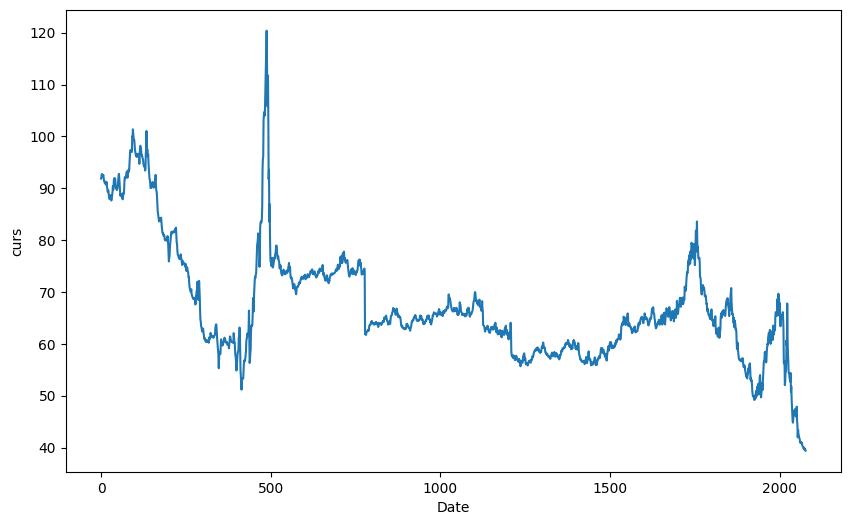

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data.dollar_curs)
plt.xlabel('Date')
plt.ylabel('curs')
plt.show()

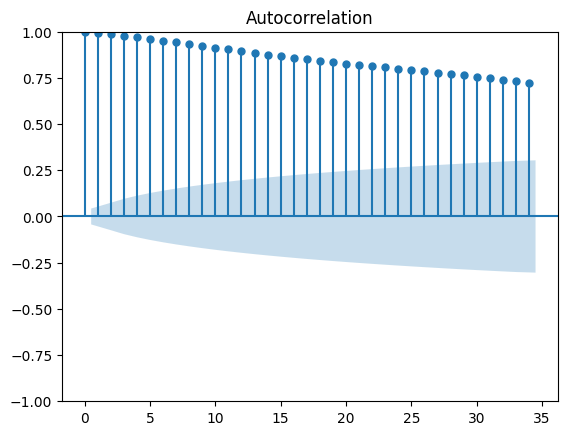

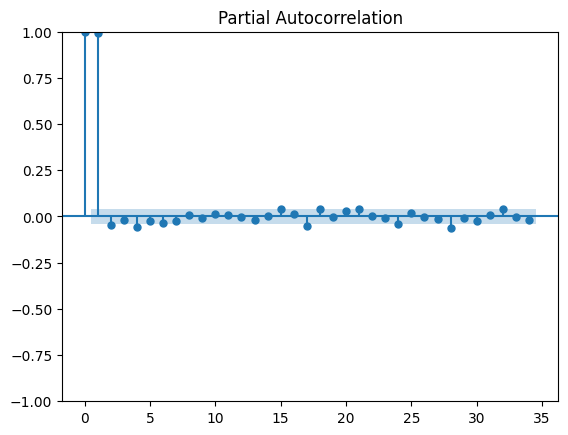

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data.dollar_curs)
plot_pacf(data.dollar_curs)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

pr_data = data.rename({"data": "date"}, axis=1)
# pr_data.date = pd.to_datetime(pr_data.date)
train = pr_data.drop(["date"], axis=1).iloc[:int(pr_data.shape[0] * 0.9)]
test = pr_data.drop(["date"], axis=1).iloc[int(pr_data.shape[0] * 0.9):]

In [10]:
X_train, y_train = train.drop("dollar_curs", axis=1), train[["dollar_curs"]]
X_test, y_test = test.drop("dollar_curs", axis=1), test[["dollar_curs"]]

In [11]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00


In [12]:
from pmdarima import auto_arima

sarimax_param = auto_arima(y_train, exogenous=X_train, m=7, start_p=0, d=1, start_q=0, start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=6491.537, Time=0.27 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=6078.830, Time=0.56 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=7.50 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=6485.199, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=5822.602, Time=1.76 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=5644.558, Time=2.68 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=27.08 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=11.94 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=5658.096, Time=1.26 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=5646.177, Time=1.90 sec
 ARIMA(1,1,1)(3,1,0)[7]             : AIC=5642.480, Time=2.64 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=5821.564, Time=3.54 sec
 ARIMA(1,1,1)(3,1,1)[7]             : AIC=inf, Time=16.45 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=inf, Time=11.02 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=5643.888, Ti

In [13]:
sarimax_param.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (3, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

algorithm = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=sarimax_param.get_params()["order"],
    seasonal_order=sarimax_param.get_params()["seasonal_order"])
model = algorithm.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# forecast the data
forecast = model.get_prediction(
    exog=pr_data.drop("dollar_curs", axis=1), dynamic=True
)
prediction = forecast.predicted_mean
ci = forecast.conf_int()

# check error rate
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("The error rates of the SARIMAX forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

ValueError: Found input variables with inconsistent numbers of samples: [208, 1869]

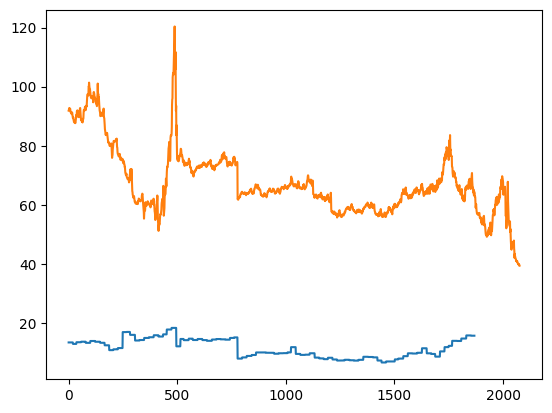

In [16]:
plt.plot(prediction)
plt.plot(pr_data.dollar_curs)

In [17]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.banki.ru/investment/shares/popular/'
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    # print(soup)
    shares = soup.find_all('div', class_='company-info')
    for share in shares:
        company_name = share.find('a', class_='company-name').text
        price_change = share.find('span', class_='price-change-value').text
        print(company_name, price_change)
        # df['Company'] = company.df.apply
print(response.status_code)

200


In [18]:
df = pd.read_csv('Df.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: 'Df.csv'

In [19]:
df

,begin,SNGS
0,2022-05-25 00:00:00,22.490
1,2022-05-26 00:00:00,23.220
2,2022-05-27 00:00:00,23.020
3,2022-05-30 00:00:00,23.005
4,2022-05-31 00:00:00,22.265
...,...,...
470,2024-03-29 00:00:00,29.880
471,2024-04-01 00:00:00,31.225
472,2024-04-02 00:00:00,30.890
473,2024-04-03 00:00:00,31.050


In [21]:
df = df.drop(columns='REGNUMBER')

KeyError: "['REGNUMBER'] not found in axis"

In [20]:
df = df.drop(columns='LISTLEVEL')

KeyError: "['LISTLEVEL'] not found in axis"

In [22]:
df = df.drop(columns='SECTYPE')

KeyError: "['SECTYPE'] not found in axis"

In [23]:
df = df.drop(columns='CURRENCYID')

KeyError: "['CURRENCYID'] not found in axis"

In [24]:
df

,begin,SNGS
0,2022-05-25 00:00:00,22.490
1,2022-05-26 00:00:00,23.220
2,2022-05-27 00:00:00,23.020
3,2022-05-30 00:00:00,23.005
4,2022-05-31 00:00:00,22.265
...,...,...
470,2024-03-29 00:00:00,29.880
471,2024-04-01 00:00:00,31.225
472,2024-04-02 00:00:00,30.890
473,2024-04-03 00:00:00,31.050


In [25]:
data

,dollar_curs,data,rate,inflation,euro_curs,pound_curs,yuan_curs
0,91.8692,2024-02-29 00:00:00,16.0,7.69,99.4500,116.5177,12.7085
1,92.0425,2024-02-28 00:00:00,16.0,7.69,99.4500,116.5177,12.7085
2,92.6321,2024-02-27 00:00:00,16.0,7.69,99.4500,116.5177,12.7085
3,92.7519,2024-02-23 00:00:00,16.0,7.69,99.4500,116.5177,12.7085
4,92.4387,2024-02-22 00:00:00,16.0,7.69,99.4500,116.5177,12.7085
...,...,...,...,...,...,...,...
2072,39.9820,2014-10-07 00:00:00,8.0,8.29,54.6378,69.3181,70.9567
2073,39.6980,2014-10-04 00:00:00,8.0,8.29,54.6378,69.3181,70.9567
2074,39.5474,2014-10-03 00:00:00,8.0,8.29,54.6378,69.3181,70.9567
2075,39.6604,2014-10-02 00:00:00,8.0,8.29,54.6378,69.3181,70.9567


# *Парсинг ключевой ставки ЦБ*

---



In [26]:
import os
import warnings
from datetime import datetime

import pandas as pd
import requests

from bs4 import BeautifulSoup

warnings.filterwarnings("ignore")


class Parser:
    RATE_TEMPLATE = (
        "https://www.cbr.ru/Queries/UniDbQuery/DownloadExcel/132934?"
        "FromDate=10%2F05%2F2014&"
        "ToDate={day:0>2}%2F{month:0>2}%2F{year}&posted=False"
    )

    def __init__(self):
        self.rate = pd.DataFrame()

    def get_rate(self):
        url = self.RATE_TEMPLATE.format(
            day=datetime.now().day,
            month=datetime.now().month,
            year=datetime.now().year
        )
        self.rate = pd.read_excel(url)
        print("RATE PARSED")

    def get_data(self):
        self.get_rate()
        rate = self.rate.rename(columns={
            "Дата": "date2",
            "Ключевая ставка, % годовых": "rate",
            "Инфляция, % г/г": "inflation"
        })
        rate.date2 = rate.date2.apply(lambda x: "{}-{:0>2}".format(*str(x).split(".")[::-1]))
        return rate


Parser().get_data().to_csv("result_key_rate.csv", index=False)

RATE PARSED


In [27]:
data = pd.read_csv('result_key_rate.csv').drop("Цель по инфляции", axis=1)

In [28]:
data

,date2,rate,inflation
0,2024-02,16.0,7.69
1,2024-01,16.0,7.44
2,2023-12,16.0,7.42
3,2023-11,15.0,7.48
4,2023-10,15.0,6.69
...,...,...,...
108,2015-02,15.0,16.70
109,2015-01,17.0,14.96
110,2014-12,17.0,11.35
111,2014-11,9.5,9.06


# **Парсинг акций**

In [29]:
import requests
import pandas as pd

names = ["YNDX", "SBER", "GAZP", "LKOH", "GMKN", "MGNT", "ROSN", "VTBR", "NVTK", "SNGS"]


def downl(name):
    req = requests.get(f"http://iss.moex.com/iss/engines/stock/markets/shares/securities/{name}/candles.json?from=2022-05-25&till=2024-04-21&interval=24").json()
    df = pd.DataFrame(req['candles']['data'], columns=req['candles']['columns'])
    return df[['begin', 'close']]


data = downl("YNDX")
data.rename(columns={'close': "YNDX"}, inplace=True)

for i in range(1, len(names)):
  df = downl(f"{names[i]}")
  df.rename(columns={'close': f"{names[i]}"}, inplace=True)
  data = pd.merge(data, df, on='begin', how='left')

data

,begin,YNDX,SBER,GAZP,LKOH,GMKN,MGNT,ROSN,VTBR,NVTK,SNGS
0,2022-05-25 00:00:00,1608.0,124.15,271.40,4148.0,20080.0,4576.0,378.00,0.018810,942.0,22.490
1,2022-05-26 00:00:00,1670.0,123.00,295.89,4263.0,20198.0,4610.0,391.70,0.018800,977.4,23.220
2,2022-05-27 00:00:00,1644.0,121.22,294.50,4290.0,20162.0,4520.0,401.50,0.018600,960.2,23.020
3,2022-05-30 00:00:00,1597.6,120.67,300.80,4220.0,20132.0,4622.0,385.10,0.018300,944.6,23.005
4,2022-05-31 00:00:00,1567.8,118.30,293.75,4061.5,20190.0,4640.0,377.00,0.018310,910.0,22.265
...,...,...,...,...,...,...,...,...,...,...,...
470,2024-03-29 00:00:00,3994.0,298.72,157.22,7551.0,15110.0,7896.0,565.75,0.022925,1312.6,29.880
471,2024-04-01 00:00:00,3975.0,300.43,158.06,7665.0,15054.0,7943.0,568.85,0.023295,1316.6,31.225
472,2024-04-02 00:00:00,3868.0,300.38,164.18,7654.0,NaN,7818.0,572.90,0.023630,1283.2,30.890
473,2024-04-03 00:00:00,3920.2,306.72,162.63,7686.5,NaN,7804.0,576.90,0.023670,1287.0,31.050
